In [107]:
import json
from im2gps.data.flickr_repo import FlickrPhoto
from mongoengine import connect
import pandas as pd
from dataclasses import make_dataclass
import seaborn as sns
from random import sample
import matplotlib.pyplot as plt

from im2gps.data.data import ImageLoader

%matplotlib inline

In [4]:
path_to_results= "/home/andrew/Documents/study/thesis/thesis-src/output/localisation-results.json"
with open(path_to_results, 'r') as f:
    results = json.load(f)
print(results.keys())

dict_keys(['accuracy', 'errors', 'predictions_by_dist', 'img_dist_error', 'img_predicted_coords'])


In [6]:
print(json.dumps(results['accuracy'], indent=4))
print(json.dumps(results['predictions_by_dist'], indent=4))

{
    "1m": 0.0008673026886383347,
    "5m": 0.009106678230702514,
    "10m": 0.029054640069384217,
    "100m": 0.2688638334778838,
    "500m": 0.4349522983521249,
    "1km": 0.5229835212489159,
    "5km": 0.7033824804856895
}
{
    "0m to 10m": 0.029054640069384217,
    "10m to 100m": 0.23980919340849957,
    "100m to 500m": 0.16608846487424112,
    "500m to 1km": 0.08803122289679098,
    "1km to 5km": 0.18039895923677363,
    "5km to 10km": 0.013009540329575022,
    "10km+": 0.28360797918473546
}


# Accuracy by regions

In [11]:
connect(db="im2gps", host="localhost", port=51998)

MongoClient(host=['localhost:51998'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary())

In [41]:
ids = [int(photo_id) for photo_id in results['img_dist_error']]
by_regions = {region:[] for region in FlickrPhoto.objects.distinct(field="geo.region")}
no_region = []
for photo_id in ids:
    photo = FlickrPhoto.objects(photo_id=photo_id).first()
    if not photo.geo.region:
        no_region.append(photo.photo_id)
    else:
        by_regions[photo.geo.region].append(photo.photo_id)
        
len(no_region)

94

In [73]:
# compute accuracy by region
Accuracy = make_dataclass("Accuracy", [("region", str), ("acc_10m", float), ("acc_100m", float), ("acc_500m", float), ("acc_1km", float), ("acc_5km", float)])
accuracy_by_region = {} 
for region in by_regions.keys():
    tmp = {
    "10m": [],
    "100m": [],
    "500m": [],
    "1km": [],
    "5km": []
    }
    for photo_id in by_regions[region]:
        dist = results["img_dist_error"][str(photo_id)]
        tmp['10m'].append(1 if dist <=0.01 else 0)
        tmp['100m'].append(1 if dist <=0.1 else 0)
        tmp['500m'].append(1 if dist <=0.5 else 0)
        tmp['1km'].append(1 if dist <=1 else 0)
        tmp['5km'].append(1 if dist <=5 else 0)
    
    accuracy_by_region[region] = {scale: -1 for scale in tmp.keys()}
    for scale, values in tmp.items():
        acc = sum(values)/len(values)
        
        accuracy_by_region[region][scale]=acc

accuracy_list = []
for region, acc in accuracy_by_region.items():
    accuracy_list.append(Accuracy(region, acc['10m'], acc['100m'], acc['500m'], acc['1km'], acc['5km']))
    
accuracy_df = pd.DataFrame(accuracy_list)

In [74]:
accuracy_df["id"]=accuracy_df.index
accuracy_df_long = pd.wide_to_long(accuracy_df, "acc", i="id", j="scale", sep="_", suffix='\w+')

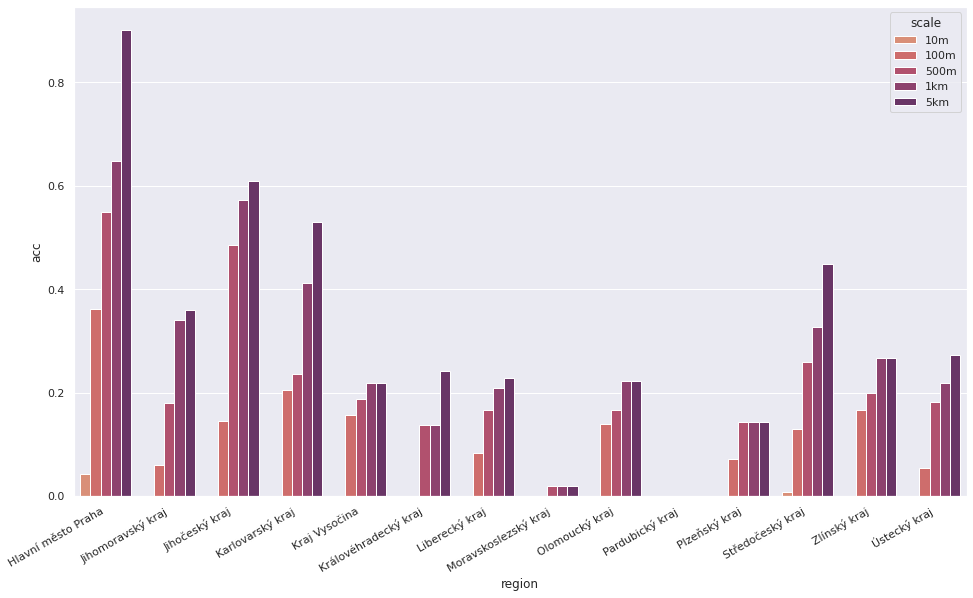

In [89]:
g=sns.barplot(data=accuracy_df_long.reset_index(), x="region", y="acc", hue="scale", palette="flare")
sns.set(rc={'figure.figsize':(9,18)})
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right');

# Where errors come from

In [161]:
by_region_10km = {region:[] for region in FlickrPhoto.objects.distinct(field="geo.region")}
ids_10km = []
for photo_id, dist in results['img_dist_error'].items():
    if dist < 10.0:
        continue
    photo = FlickrPhoto.objects(photo_id=int(photo_id)).first()
    region = photo.geo.region
    ids_10km.append(int(photo_id))
    if region is None:
        pass
    else:
        by_region_10km[region].append(photo_id)
    
region_proportion = make_dataclass("region_proportion", [("region", str), ("proportion", float), ("proprtion_of_region")])
reg_prop_list = []
for region, values in by_region_10km.items():
    proportion = len(values)/len(ids_10km)
    proportion_of_region = len(values)/len(by_regions[region])
    reg_prop_list.append(region_proportion(region, proportion, proportion_of_region))
    
df = pd.DataFrame(reg_prop_list)
    

In [162]:
df

region  proportion  proprtion_of_region
0     Hlavní město Praha    0.195719             0.084155
1      Jihomoravský kraj    0.097859             0.640000
2         Jihočeský kraj    0.079511             0.376812
3       Karlovarský kraj    0.024465             0.470588
4          Kraj Vysočina    0.038226             0.781250
5   Královéhradecký kraj    0.029052             0.655172
6         Liberecký kraj    0.056575             0.770833
7   Moravskoslezský kraj    0.074924             0.980000
8         Olomoucký kraj    0.041284             0.750000
9        Pardubický kraj    0.012232             0.888889
10         Plzeňský kraj    0.018349             0.857143
11      Středočeský kraj    0.097859             0.551724
12          Zlínský kraj    0.033639             0.733333
13          Ústecký kraj    0.061162             0.727273

# Densities

In [168]:
densities_df = pd.read_csv("/home/andrew/Documents/study/thesis/thesis-src/results/test_densities.csv")
densities_df["id"] = densities_df.index
densities_df

photo_id  density_10m  density_100m  density_500m  density_1km    id
0       114761145            7           241          6614        38609     0
1       114761148            7           241          6614        38609     1
2       114761147            7           241          6614        38609     2
3       114761146            7           241          6614        38609     3
4       107623469            4           553         23939        69324     4
...           ...          ...           ...           ...          ...   ...
2301  50128720096            0             0             0            0  2301
2302  50128150238            0             0             0            0  2302
2303  50128149938            0             0             0            0  2303
2304  50128938092            0             0             0            1  2304
2305  50580492607         1113         10867         29502        60727  2305

[2306 rows x 6 columns]

In [172]:
densities_df_long = pd.wide_to_long(densities_df, "density", i="id", j="density_level", sep="_", suffix='\w+').reset_index()


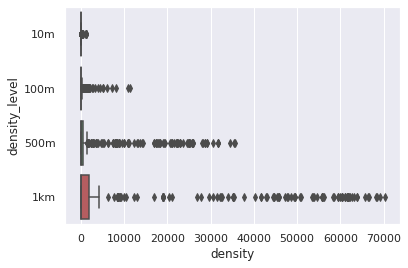

In [195]:
# g=sns.kdeplot(data=density_10km_df, x="density", clip=(0,10000))
g=sns.boxplot(data=density_10km_df, x="density", y='density_level')

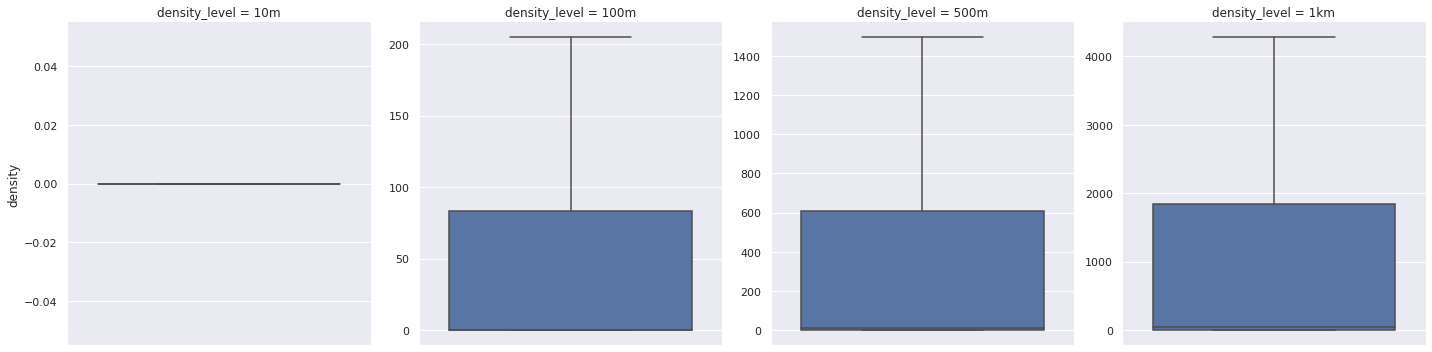

In [205]:
density_10km_df = densities_df_long.loc[densities_df_long['photo_id'].isin(ids_10km)]
g=sns.catplot(
    data=density_10km_df, y='density',
    col='density_level', kind='box', sharey=False, showfliers=False
)

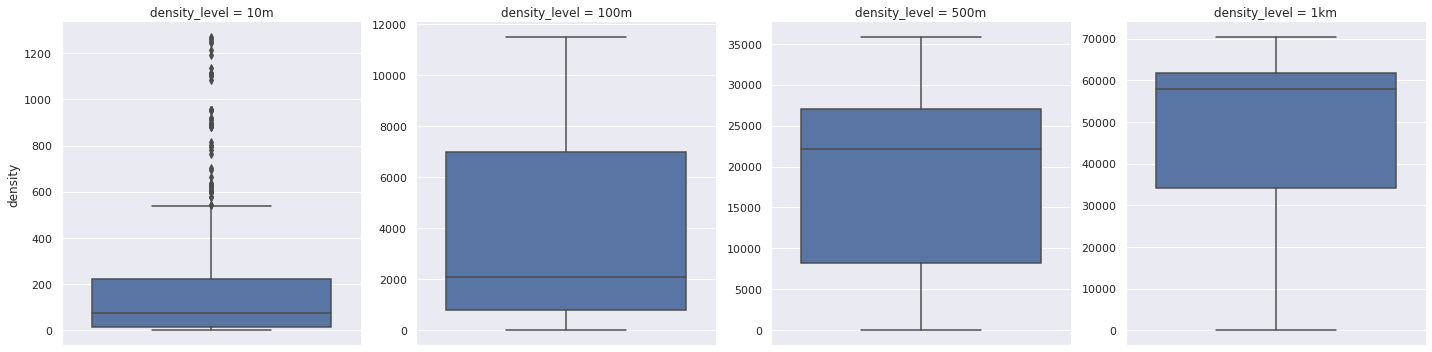

In [201]:
density_100m_df = densities_df_long.loc[densities_df_long['photo_id'].isin(ids_100m)]
g=sns.catplot(
    data=density_100m_df, y='density',
    col='density_level', kind='box', sharey=False
)

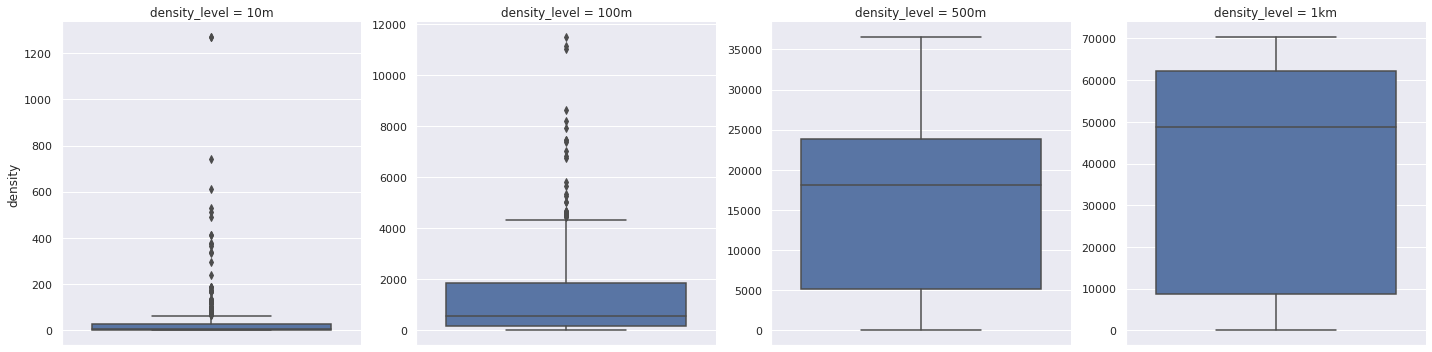

In [203]:
density_500m_df = densities_df_long.loc[densities_df_long['photo_id'].isin(ids_500m)]
g=sns.catplot(
    data=density_500m_df, y='density',
    col='density_level', kind='box', sharey=False
)

# Show images

In [95]:
root_dir = "/media/andrew/TRANSCEND/Study/master-thesis/data" 
img_loader = ImageLoader(root_dir)

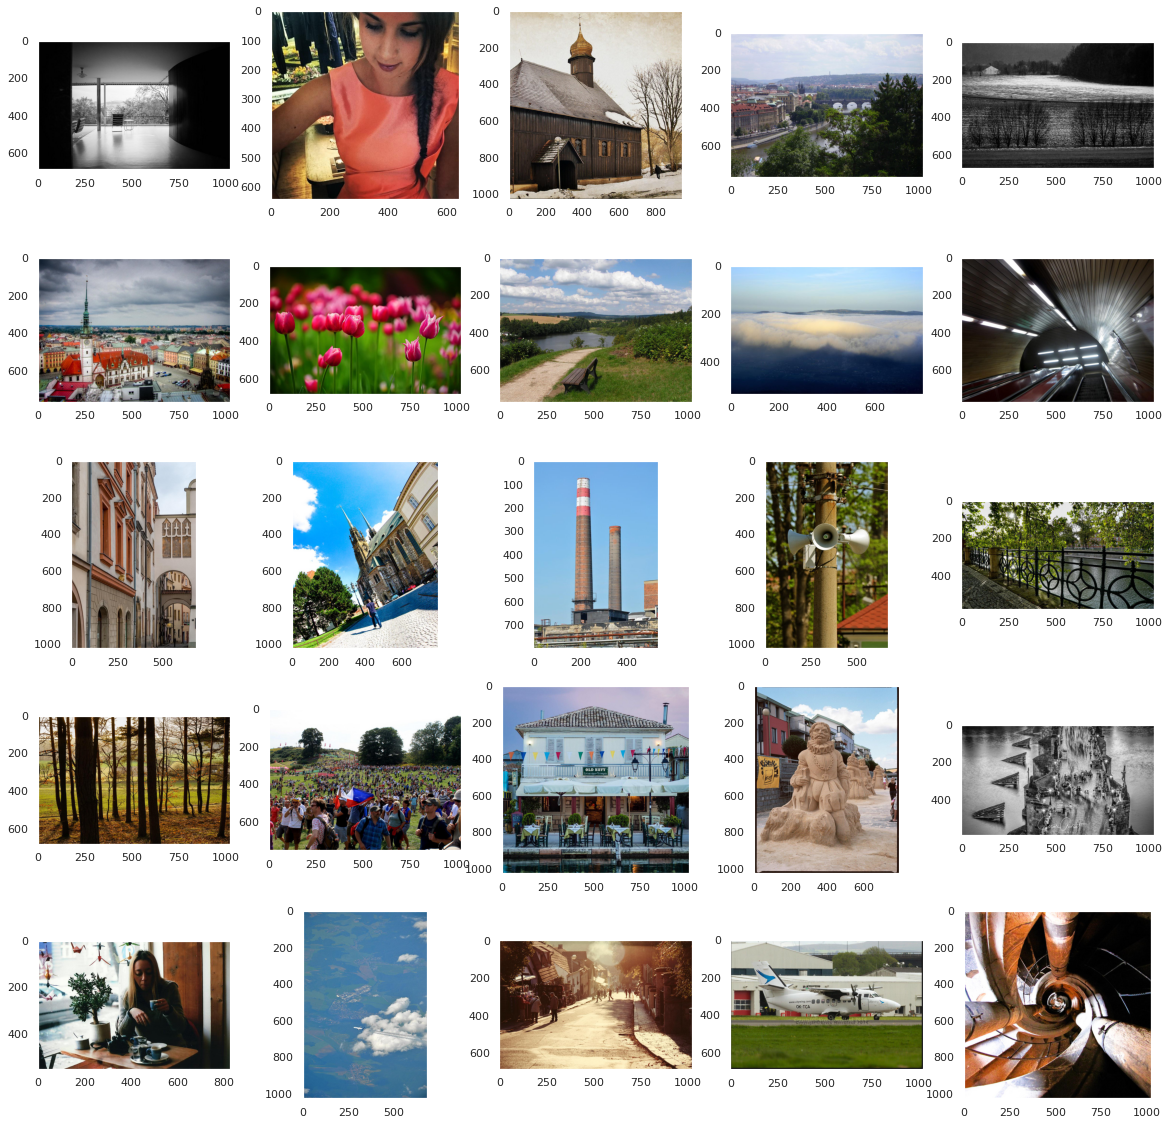

In [150]:
ids_10km = []
for photo_id, dist in results['img_dist_error'].items():
    if dist >= 10:
        ids_10km.append(int(photo_id))

images = []        
img_sample = sample(ids_10km, 25)
for img_id in img_sample:
    images.append(img_loader.get_image_by_id(img_id))
        
fig, axes = plt.subplots(5,5, figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ax.grid(False)
    ax.imshow(images[i])

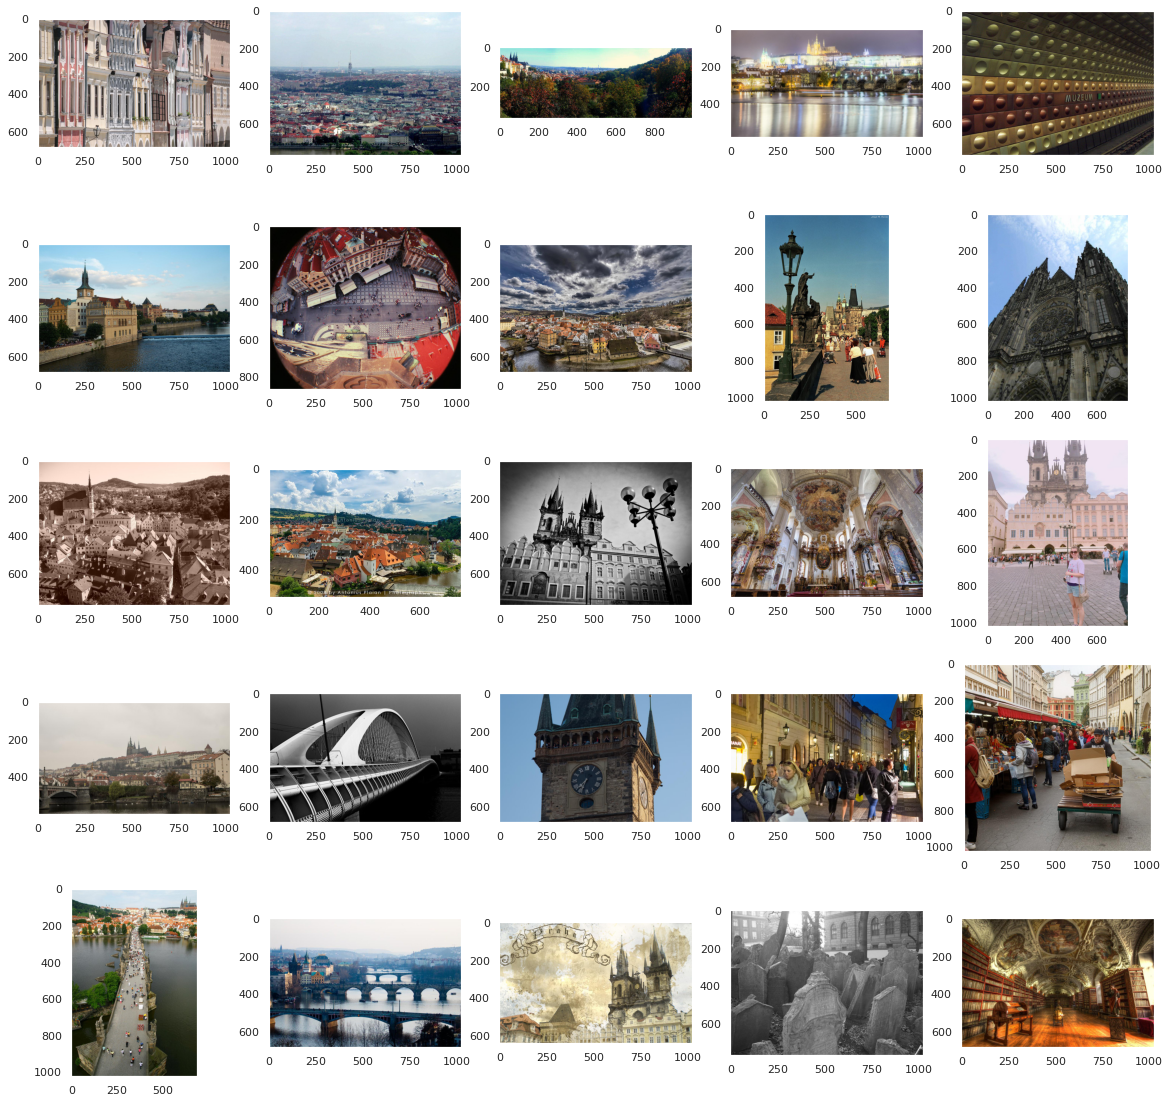

In [152]:
ids_100m = []
for photo_id, dist in results['img_dist_error'].items():
    if dist <= 0.1:
        ids_100m.append(int(photo_id))
        
images = []
img_sample = sample(ids_100m, 25)
for img_id in img_sample:
    images.append(img_loader.get_image_by_id(img_id))
    
fig, axes = plt.subplots(5,5, figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ax.grid(False)
    ax.imshow(images[i])

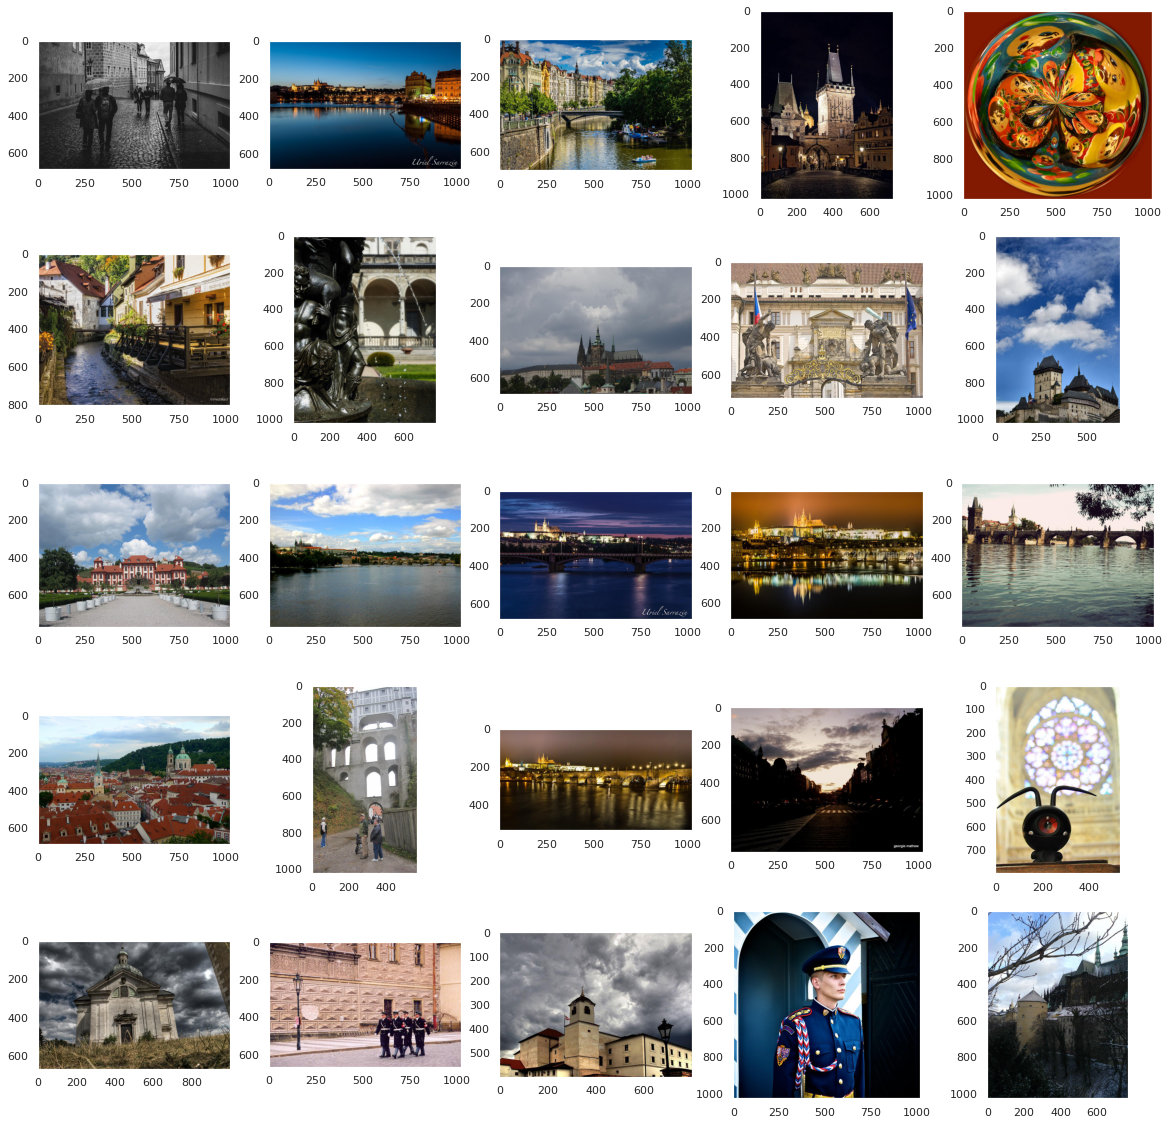

In [159]:
ids_500m = []
for photo_id, dist in results['img_dist_error'].items():
    if dist > 0.1 and dist <= 0.5:
        ids_500m.append(int(photo_id))
        
images = []
img_sample = sample(ids_500m, 25)
for img_id in img_sample:
    images.append(img_loader.get_image_by_id(img_id))
    
fig, axes = plt.subplots(5,5, figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ax.grid(False)
    ax.imshow(images[i])